# GDAL and OGR libraries

In the previous session, we used the GDAL library to open HDF files. GDAL is not limited to a single file format, but can actually cope with many different raster file formats semalessly. For *vector* data (i.e., data that is stored by features, each being made up of fields containing different types of information, one of them being a *geometry*, such as polygon, line or point), GDAL has a sister library called OGR. The usefulness of these two libraries is that they allow the user to deal with many of the different file formats in a consistent way. 

It is important to note that both GDAL and OGR come with a suite of command line tools that let you do many complex tasks on the command line directly. A listing of the GDAL command line tools is available [here](http://www.gdal.org/gdal_utilities.html), but bear in mind that many blogs etc. carry out examples of using GDAL tools in practice. For OGR, most of the library can be accessed using [ogr2ogr](http://www.gdal.org/ogr2ogr.html), but as usual, you might find more useful information on [blogs](http://www.bostongis.com/PrinterFriendly.aspx?content_name=ogr_cheatsheet) etc.

## GDAL data type

GDAL provides a very handy way of dealing with raster data in many different formats, not only by making access to the data easy, but also abstracting the nuances and complications of different file formats. In GDAL, a raster file is made up of the actual raster data (i.e.,  the values of each pixel of LAI that we saw before), and of some *metadata*. Metadata is data that describes something, and in this case it could be the projection, the location of corners and pixel spacing, etc.

### The GeoTransform

GDAL stores information about the location of each pixel using the GeoTransform. The GeoTransform contains the coordinates (in some projection) of the upper left (UL) corner of the image (taken to be the **borders of the pixel** in the UL corner, not the center), the pixel spacing and an additional rotation. By knowing these figures, we can calculate the location of each pixel in the image easily. Let's see how this works with an easy example. We have prepared a GeoTIFF file (GeoTIFF is the more ubiquitous file format for EO data) of the MODIS landcover product for the UK. The data has been extracted from the HDF-EOS files that are similar to the LAI product that we have seen before, and converted. The file is [`lc_h17v03.tif`](https://raw.github.com/jgomezdans/geogg122/master/ChapterX_GDAL/lc_h17v03.tif). We will open the file in Python, and have a look at finding a particular location.

Assume we are interested in locating [Kinder Scout](http://toolserver.org/~rhaworth/os/coor_g.php?pagename=Kinder_Scout&params=SK086875_region%3AGB_scale%3A25000), a moorland in the Peak District National Park. Its coordinates are 1.871417W, 53.384726N. In the MODIS integerised sinusoidal projection, the coordinates are (-124114.3, 5936117.4) (you can use the [MODLAND tile calculator website](http://landweb.nascom.nasa.gov/cgi-bin/developer/tilemap.cgi) to do this calculation yourself).

In [1]:
import gdal # Import GDAL library

# have to make sure have access to gdal data files 
import os
if 'GDAL_DATA' not in os.environ:
    os.environ["GDAL_DATA"] = '/opt/anaconda/share/gdal'


g = gdal.Open ( "lc_h17v03.tif" ) # Open the file
if g is None:
    print "Could not open the file!"
geo_transform = g.GetGeoTransform ()
print geo_transform
print g.RasterXSize, g.RasterYSize

(-1111950.519667, 463.3127165279167, 0.0, 6671703.118, 0.0, -463.3127165279165)
2400 2400


In the previous code, we open the file (we just use the filename), and then query the object for its GeoTransform, which we then print out. The 6-element tuple comprises 

1. The Upper Left *easting* coordinate (i.e., *horizontal*)
2. The E-W pixel spacing
3. The rotation (0 degrees if image is "North Up")
4. The Upper left *northing* coordinate (i.e., *vertical*)
5. The rotation (0 degrees)
6. The N-S pixel spacing, negative as we will be counting from the UL corner

We have also seen that the dataset is of size 2400x2400, using `RasterXSize` and `RasterYSize`. The goal is to find the pixel number $(i,j), \;\;0\le i,j < 2400$ that corresponds to Kinder Scout. To do this, we use the following calculations:

In [2]:
pixel_x = (-124114.3 - geo_transform[0])/geo_transform[1] \
        # The difference in distance between the UL corner (geot[0] \
        #and point of interest. Scaled by geot[1] to get pixel number

pixel_y = (5936117.4 - geo_transform[3])/(geo_transform[5]) # Like for pixel_x, \
        #but in vertical direction. Note the different elements of geot \
        #being used

print pixel_x, pixel_y

2132.11549009 1587.66572071


So the pixel number is a floating point number, which we might need to round off as an integer. Let's plot the entire raster map (with minimum value 0 to ignore the ocean) using [`plt.imshow`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) and plot the location of Kinder Scout using [`plt.plot`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plt). We will also use [`plt.annotate`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate) to add a label with an arrow:

([], <a list of 0 Text yticklabel objects>)

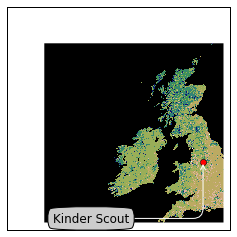

In [3]:
lc = g.ReadAsArray() # Read raster data
# Now plot the raster data using gist_earth palette
plt.imshow ( lc, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth )
# Plot location of our area of interest as a red dot ('ro')
plt.plot ( pixel_x, pixel_y, 'ro')
# Annotate
plt.annotate('Kinder Scout', xy=(pixel_x, pixel_y),  \
        xycoords='data', xytext=(-150, -60), \
        textcoords='offset points',  size=12, \
        bbox=dict(boxstyle="round4,pad=.5", fc="0.8"), \
        arrowprops=dict(arrowstyle="->", \
        connectionstyle="angle,angleA=0,angleB=-90,rad=10", \
        color='w'), )
# Remove vertical and horizontal ticks
plt.xticks([])
plt.yticks([])

#### Try it out in some other places!

Find the longitude and latitude of some places of interest in the British isles (West of Greenwich!) and using the MODLAND MODIS tile calculator and the geotransform, repeat the above experiment. Note that the [MODIS calculator](http://landweb.nascom.nasa.gov/cgi-bin/developer/tilemap.cgi) calculates both the projected coordinates in the MODIS sinusoidal projection, as well as the pixel number, so it is a helpful way to check whether you got the right result.
<td>
</td>
<table>
<tr>
<th>Park name</th><th>Longitude [deg]</th><th>Latitude [deg]</th>
</tr>
<tr>
<td>Dartmoor national park</td>	<td>-3.904</td><td>	50.58</td>
</tr>
<tr>
<td>New forest national park</td><td>	-1.595</td><td>	50.86</td>
</tr>
<tr>
<td>Exmoor national park</td><td>	-3.651</td><td>	51.14</td>
</tr>
<tr>
<td>Pembrokeshire coast national park</td><td>	-4.694</td><td>	51.64</td>
</tr>
<tr>
<td>Brecon beacons national park	</td><td>-3.432</td><td>	51.88</td>
</tr>
<tr>
<td>Pembrokeshire coast national park</td><td>	-4.79</td><td>	51.99</td>
</tr>
<tr>
<td>Norfolk and suffolk broads	</td><td>1.569</td><td>	52.62</td>
</tr>
<tr>
<td>Snowdonia national park</td><td>	-3.898	</td><td>52.9</td>
</tr>
<tr>
<td>Peak district national park	</td><td>-1.802	</td><td>53.3</td>
</tr>
<tr>
<td>Yorkshire dales national park</td><td>	-2.157	</td><td>54.23</td>
</tr>
<tr>
<td>North yorkshire moors national park	</td><td>-0.8855	</td><td>54.37</td>
</tr>
<tr>
<td>Lake district national park	</td><td>-3.084	</td><td>54.47</td>
</tr>
<tr>
<td>Galloway forest park	</td><td>-4.171	</td><td>54.87</td>
</tr>
<tr>
<td>Northumberland national park	</td><td>-2.228	</td><td>55.28</td>
</tr>
<tr>
<td>Loch lomond and the trossachs national park	</td><td>-4.593	</td><td>56.24</td>
</tr>
<tr>
<td>Tay forest park	</td><td>-4.025</td><td>	56.59</td>
</tr>
<tr>
<td>Cairngorms national park	</td><td>-3.545	</td><td>57.08</td>
</tr>
</table>


## The projection

Projections in GDAL objects are stored can be accessed by querying the dataset using the `GetProjection()` method. If we do that on the currently opened dataset (stored in variable `g`), we get:

In [4]:
print g.GetProjection()

PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


The above is the description of the projection (in this case, MODIS sinusoidal) in `WKT` (well-known text) format. There are a number of different ways of specifying projections, the most important being

* WKT
* Proj4
* EPSG codes

The site [spatialreference.org](http://spatialreference.org) allows you to search a large collection of projections, and get the representation that you want to use. 

## Saving files

So far, we have read data from files, but lets see how we can save raster data **to** a new file. We will use the previous landcover map as an example. We will write a method to save the data in a format provided by the user. The procedure is fairly straightforward: we get a handler to a driver (e.g. a GeoTIFF or Erdas Imagine format), we create the output file (giving a filename, number of rows, columns, bands, the data type), and then add the relevant metadata (projection, geotransform, ...). We then select a band from the output and copy the array that we want to write to that band.

In [5]:
g = gdal.Open ( "lc_h17v03.tif" ) # Open original file
# Get the x, y and number of bands from the original file
x_size, y_size, n_bands = g.RasterXSize, g.RasterYSize, g.RasterCount
data = g.ReadAsArray ()
driver = gdal.GetDriverByName ( "HFA" ) # Get a handler to a driver
                                        # Maybe try "GeoTIFF" here
# Next line creates the output dataset with
# 1. The filename ("test_lc_h17v03.img")
# 2. The raster size (x_size, y_size)
# 3. The number of bands
# 4.The data type (in this case, Byte.
#     Other typical values might be gdal.GDT_Int16 
#     or gdal.GDT_Float32)

dataset_out = driver.Create ( "test_lc_h17v03.img", x_size, y_size, n_bands, \
                             gdal.GDT_Byte )
# Set the output geotransform by reading the input one
dataset_out.SetGeoTransform ( g.GetGeoTransform() )
# Set the output projection by reading the input one
dataset_out.SetProjection ( g.GetProjectionRef() )
# Now, get band # 1, and write our data array. 
# Note that the data array needs to have the same type
# as the one specified for dataset_out
dataset_out.GetRasterBand ( 1 ).WriteArray ( data )
# This bit forces GDAL to close the file and write to it
dataset_out = None

The output file should hopefully exist in this directory. Let's use [`gdalinfo`](http://www.gdal.org/gdalinfo.html) to find out about it

In [6]:
!gdalinfo test_lc_h17v03.img

gdalinfo: error while loading shared libraries: libxerces-c-3.1.so: cannot open shared object file: No such file or directory


So the previous code works. Since this is something we typically do (read some data from one or more files, manipulate it and save the result in output files), it makes a lot of sense to try to put this code in a method that is more or less generic, that we can test and then re-use. Here's a first attempt at it:

In [7]:
def save_raster ( output_name, raster_data, dataset, driver="GTiff" ):
    """
    A function to save a 1-band raster using GDAL to the file indicated
    by ``output_name``. It requires a GDAL-accesible dataset to collect 
    the projection and geotransform.
    
    Parameters
    ----------
    output_name: str
        The output filename, with full path and extension if required
    raster_data: array
        The array that we want to save
    dataset: str
        Filename of a GDAL-friendly dataset that we want to use to
        read geotransform & projection information
    driver: str
        A GDAL driver string, like GTiff or HFA.
    """
    
    # Open the reference dataset
    g = gdal.Open ( dataset )
    # Get the Geotransform vector
    geo_transform = g.GetGeoTransform ()
    x_size = g.RasterXSize # Raster xsize
    y_size = g.RasterYSize # Raster ysize
    srs = g.GetProjectionRef () # Projection
    # Need a driver object. By default, we use GeoTIFF
    driver = gdal.GetDriverByName ( driver )
    dataset_out = driver.Create ( output_name, x_size, y_size, 1, \
            gdal.GDT_Float32 )
    dataset_out.SetGeoTransform ( geo_transform )
    dataset_out.SetProjection ( srs )
    dataset_out.GetRasterBand ( 1 ).WriteArray ( \
            raster_data.astype(np.float32) )
    dataset_out = None

Now try modifying that method so that you can

1. Select the output data type diffrent to Float32
2. Provide a given projection and geotransform (e.g. if you don't have a GDAL filename)

## Reprojecting things

Previously, we have used the [MODLAND grid converter](http://landweb.nascom.nasa.gov/cgi-bin/developer/tilemap.cgi) site to go from latitude/longitude pairs to MODIS projection. However, in practice, we might want to use a range of different projections, and convert many points at the same time, so how do we go about that?

In GDAL/OGR, most projection-related tools are in the `osr` package, which needs to be imported like e.g. `gdal` itself. The main tools are the `osr.SpatialReference` object, which defines a projection object (with no projection to start with), and the `osr.CoordinateTransformation` object. 

Once you instantiate `osr.SpatialReference`, it holds no projection information. You need to use methods to set it up, using EPSG codes, Proj4 strings, or whatever. These methods typically start by `ImportFrom` (e.g. `ImportFromEPSG`, `ImportFromProj4`, ...).

The `CoordinateTransformation` requires a source and destination spatial references that have been configured. Once this is done, it expose the method `TransformPoint` to convert coordinates from the source to the destination projection.

Let's see how this works by converting some latitude/longitude pairs to the Ordnance Survey's [National Grid](http://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid) projection. The projection is also available in [spatialreference.org](http://spatialreference.org/ref/epsg/27700/), where we can gleam its EPSG code (27700). The EPSG code for longitude latitude is [4326](http://spatialreference.org/ref/epsg/4326/). Let's see this in practice:


In [8]:
from osgeo import osr, ogr

# Define the source projection, WGS84 lat/lon. 
wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code

# Now for the target projection, Ordnance Survey's British National Grid
osng = osr.SpatialReference() # define the SpatialReference object
# In this case, we get the projection from a Proj4 string
osng.ImportFromEPSG( 27700)
# or, if using the proj4 representation
#osng.ImportFromProj4 ( "+proj=tmerc +lat_0=49 +lon_0=-2 " + \
#                      "+k=0.9996012717 +x_0=400000 +y_0=-100000 " + \
#                      "+ellps=airy +datum=OSGB36 +units=m +no_defs" )


# Now, we define a coordinate transformtion object, *from* wgs84 *to* OSNG
tx = osr.CoordinateTransformation( wgs84, osng)
# We loop over the lines of park_data, 
#         using the split method to split by newline characters
park_name, lon, lat = "Snowdonia national park", -3.898,52.9

# create a geometry from coordinates
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(lon, lat)

# Actually do the transformation using the TransformPoint method
point.Transform ( tx )

osng_x = point.GetX()
osng_y = point.GetY()
osng_z = point.GetZ()

# Print out
print park_name, lon, lat, osng_x, osng_y, osng_z

Snowdonia national park -3.898 52.9 272430.177073 335304.936492 -51.8129037432


You can test the result is reasonable by feeding the data for `osng_x` and `osng_y` in  the OS own [coordinate conversion website](http://www.ordnancesurvey.co.uk/gps/transformation) and making sure that the calculated longitude latitude pair is the same as the one you started with.

## Reprojecting whole rasters

### Using command line tools

The easiest way to reproject a raster file is to use GDAL's [`gdalwarp`](http://www.gdal.org/gdalwarp.html) tool. As an example, let's say we want to reproject the landcover file from earlier on into latitude/longitude (WGS84):

In [9]:
%%bash
# in case you don't have library path set
# use 'locate libnetcdf` or similar if its not in here
LD_LIBRARY_PATH=/opt/anaconda/lib:$LD_LIBRARY_PATH
export LD_LIBRARY_PATH

gdalwarp -of GTiff -t_srs "EPSG:4326" -ts 2400 2400 test_lc_h17v03.img  lc_h17v03_wgs84.tif

Output dataset lc_h17v03_wgs84.tif exists,
but some commandline options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.


We see here that the command takes a number of arguments:

1. `-of GTiff` is the outut format (in this case GeoTIFF)
2. `-t_srs "EPSG:4326"` is the **to** projection (the **from** projection is already specified in the source dataset), in this case, lat/long WGS84, known by its [EPSG code](http://spatialreference.org/ref/epsg/4326/)
3. `-ts 2400 2400` instructs `gdalwarp` to use an output of size `2400*2400`.
3. `test_lc_h17v03.img` is the **input dataset**
4. `lc_h17v03_wgs84.tif` is the **output dataset**

Note that `gdalwarp` will reproject the data, and decide on the pixel size based on some considerations. This can result in the size of the raster changing. If you wanted to still keep the same raster size, we use the `-ts 2400 2400` option, or select an appropriate pixel size using `-tr xres yres` (note it has to be in the target projection, so degrees in this case). We can use `gdalinfo` to see what we've done.

In [10]:
%%bash
# in case you don't have library path set
# use 'locate libnetcdf` or similar if its not in here
LD_LIBRARY_PATH=/opt/anaconda/lib:$LD_LIBRARY_PATH
export LD_LIBRARY_PATH

pwd
gdalinfo test_lc_h17v03.img

/home/plewis/p/geogg122/Chapter4_GDAL
Driver: HFA/Erdas Imagine Images (.img)
Files: test_lc_h17v03.img
Size is 2400, 2400
Coordinate System is:
PROJCS["Sinusoidal",
    GEOGCS["GCS_Unknown datum based upon the custom spheroid",
        DATUM["Not_specified_based_on_custom_spheroid",
            SPHEROID["Custom_spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.017453292519943295]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]
Origin = (-1111950.519667000044137,6671703.117999999783933)
Pixel Size = (463.312716527916677,-463.312716527916507)
Corner Coordinates:
Upper Left  (-1111950.520, 6671703.118) ( 20d 0' 0.00"W, 60d 0' 0.00"N)
Lower Left  (-1111950.520, 5559752.598) ( 15d33'26.06"W, 50d 0' 0.00"N)
Upper Right (       0.000, 6671703.118) (  0d 0' 0.01"E, 60d 0' 0.00"N)
Lower Right (       0.000, 5559752.598) (  0d 0' 0.01"E, 50d 0' 0.00"N

In [11]:
%%bash
# in case you don't have library path set
# use 'locate libnetcdf` or similar if its not in here
LD_LIBRARY_PATH=/opt/anaconda/lib:$LD_LIBRARY_PATH
export LD_LIBRARY_PATH

gdalinfo lc_h17v03_wgs84.tif

Driver: GTiff/GeoTIFF
Files: lc_h17v03_wgs84.tif
Size is 2400, 2400
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-19.999999994952233,59.999999994611805)
Pixel Size = (0.008333919248404,-0.004166959624202)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -20.0000000,  60.0000000) ( 20d 0' 0.00"W, 60d 0' 0.00"N)
Lower Left  ( -20.0000000,  49.9992969) ( 20d 0' 0.00"W, 49d59'57.47"N)
Upper Right (   0.0014062,  60.0000000) (  0d 0' 5.06"E, 60d 0' 0.00"N)
Lower Right (   0.0014062,  49.9992969) (  0d 0' 5.06"E, 49d59'57.47"N)
Center      (  -9.9992969,  54.9996484) (  9d59'57.47"W, 54d59'58.73"N)
Band 1 Block=2400x3 Type=Byte, ColorInterp=Gray
  Description = Layer_1
  Metadata:
    LAYER_T

Let's see how different these two datasets are:

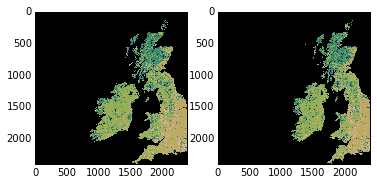

In [12]:
g = gdal.Open ( "lc_h17v03_wgs84.tif" )
wgs84 = g.ReadAsArray()
g = gdal.Open("test_lc_h17v03.img")
modis = g.ReadAsArray()
plt.subplot ( 1, 2, 1 )
plt.imshow ( modis, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth )
plt.subplot ( 1, 2, 2 )
plt.imshow ( wgs84, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth )

### Reprojecting using the Python bindings

The previous section demonstrated how you can reproject raster files using command line tools. Sometimes, you might want to do this from inside a Python script. Ideally, you would have a python method that would perform the projection for you. GDAL allows this by defining in-memory raster files. These are normal GDAL datasets, but that don’t exist on the filesystem, only in the computer’s memory. They are a convenient “scratchpad” for quick intermediate calculations. GDAL also makes available a function, gdal.ReprojectImage that exposes most of the abilities of gdalwarp. We shall combine these two tricks to carry out the reprojection. As an example, we shall look at the case where the landcover data for the British Isles mentioned in the previous section needs to be reprojected to the Ordnance Survey National Grid, an appropriate projection for the UK.

The main complication comes from the need of gdal.ReprojectImage to operate on GDAL datasets. In the previous section, we saved the data to a GeoTIFF file, so this gives us a starting dataset. We still need to create the output dataset. This means that we need to define the geotransform and size of the output dataset before the projection is made. This entails gathering information on the extent of the original dataset, projecting it to the destination projection, and calculating the number of pixels and geotransform parameters from there. This is a (heavily commented) function that performs just that task:

In [13]:
def reproject_dataset ( dataset, \
            pixel_spacing=463., epsg_from=4326, epsg_to=27700 ):
    """
    A sample function to reproject and resample a GDAL dataset from within 
    Python. The idea here is to reproject from one system to another, as well
    as to change the pixel size. The procedure is slightly long-winded, but
    goes like this:
    
    1. Set up the two Spatial Reference systems.
    2. Open the original dataset, and get the geotransform
    3. Calculate bounds of new geotransform by projecting the UL corners 
    4. Calculate the number of pixels with the new projection & spacing
    5. Create an in-memory raster dataset
    6. Perform the projection
    """
    # Define the UK OSNG, see <http://spatialreference.org/ref/epsg/27700/>
    osng = osr.SpatialReference ()
    osng.ImportFromEPSG ( epsg_to )
    wgs84 = osr.SpatialReference ()
    wgs84.ImportFromEPSG ( epsg_from )
    tx = osr.CoordinateTransformation ( wgs84, osng )
    # Up to here, all  the projection have been defined, as well as a 
    # transformation from the from to the  to :)
    # We now open the dataset
    g = gdal.Open ( dataset )
    
    # Get the Geotransform vector
    geo_t = g.GetGeoTransform ()
    x_size = g.RasterXSize # Raster xsize
    y_size = g.RasterYSize # Raster ysize
    
    # Work out the boundaries of the new dataset in the target projection
    (ulx, uly, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])
    (lrx, lry, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                          geo_t[3] + geo_t[5]*y_size )
    print ulx, uly, ulz
    print lrx, lry, lrz
    # See how using 27700 and WGS84 introduces a z-value!
    # Now, we create an in-memory raster
    mem_drv = gdal.GetDriverByName( 'MEM' )
    # The size of the raster is given the new projection and pixel spacing
    # Using the values we calculated above. Also, setting it to store one band
    # and to use Float32 data type.
    dest = mem_drv.Create('', int((lrx - ulx)/pixel_spacing), \
            int((uly - lry)/pixel_spacing), 1, gdal.GDT_Float32)
    # Calculate the new geotransform
    new_geo = ( ulx, pixel_spacing, geo_t[2], \
                uly, geo_t[4], -pixel_spacing )
    # Set the geotransform
    dest.SetGeoTransform( new_geo )
    dest.SetProjection ( osng.ExportToWkt() )
    # Perform the projection/resampling 
    res = gdal.ReprojectImage( g, dest, \
                wgs84.ExportToWkt(), osng.ExportToWkt(), \
                gdal.GRA_Bilinear )
    return dest

The function returns a GDAL in-memory file object, where you can `ReadAsArray` etc. As it stands, `reproject_dataset` does not write to disk. However, we can save the in-memory raster to any format supported by GDAL very conveniently by making a copy of the dataset. This takes a few lines of code:


In [14]:
# Do in memory reprojection
reprojected_dataset = reproject_dataset ( "lc_h17v03_wgs84.tif" )
# Output driver, as before
driver = gdal.GetDriverByName ( "GTiff" )
# Create a copy of the in memory dataset `reprojected_dataset`, and save it
dst_ds = driver.CreateCopy( "test_lc_h17v03_OSNG.tif", reprojected_dataset, 0 )
dst_ds = None # Flush the dataset to disk


-595472.202548 1261034.77555 -55.2326775854
543532.18509 12933.1712342 -43.993001678


Let's see how the different projections look like by plotting them side by side

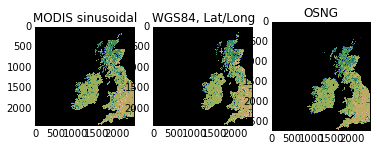

In [15]:
plt.subplot ( 1, 3, 1 )
plt.title ("MODIS sinusoidal")
plt.imshow ( modis, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth )
plt.subplot ( 1, 3, 2 )
plt.imshow ( wgs84, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth )
g = gdal.Open("test_lc_h17v03_OSNG.tif" )
osng = g.ReadAsArray()
plt.title ("WGS84, Lat/Long")
plt.subplot ( 1, 3, 3 )
plt.imshow ( osng, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth )
plt.title("OSNG")